# Galaxy classifier
## Import libraries, path and labels dict
https://www.kaggle.com/addisonkendalllr/galaxydataset

In [2]:
import numpy as np 
import pandas as pd 

import os
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import pickle as pk
import pprint
import time

from PIL import Image
from skimage.io import imread
from skimage.transform import resize

from ipywidgets import IntProgress
from IPython.display import display
from sklearn.model_selection import train_test_split

import tensorflow
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, Flatten
from keras.callbacks import ModelCheckpoint 
from tensorflow.keras.models import load_model

Train images must be in ~/image/label_x folder

In [3]:
img_files = np.array(glob("images/*"))
img_files

array(['images\\edge', 'images\\other', 'images\\smooth',
       'images\\spiral'], dtype='<U13')

In [4]:
# Create dict of breeds
target_dict = {i: img_files[i].replace('images\\','') for i in range(len(img_files))}
target_dict

{0: 'edge', 1: 'other', 2: 'smooth', 3: 'spiral'}

## Image pre-processing

In [5]:
# Define image size to be transfered to the CNN
size = (128, 128)

In [6]:
# Load and resize image + store in array
def load_images(folder):
    images = []
    target = []
    for i in range(len(folder)):
        
        # print progress and number of files   
        num_file = len(os.listdir(folder[i]))
        print('label',str(i)+'/'+str(len(folder)-1)+' path:',folder[i], str(num_file)+" files")
        
        # Progress bar
        max_count = num_file
        f = IntProgress(min=0, max=max_count) # instantiate the bar
        display(f) # display the bar
        
        # load and resize images from a folder
        for filename in os.listdir(folder[i]):
            f.value += 1
            img = imread(os.path.join(folder[i], filename), as_gray=False)
            if img is not None:
                # resize image
                img = resize(img, size, mode='reflect')
                # convert to np array
                img = np.asarray(img)
                # append image list and target list
                images.append(img)
                target.append(i)       
                
    return images, target

In [7]:
X, y = load_images(img_files)

label 0/3 path: images\edge 100 files


IntProgress(value=0)

label 1/3 path: images\other 100 files


IntProgress(value=0)

label 2/3 path: images\smooth 100 files


IntProgress(value=0)

label 3/3 path: images\spiral 100 files


IntProgress(value=0)

image dimension: (128, 128, 3)


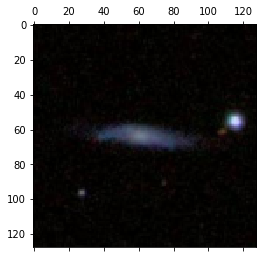

In [8]:
def display_example(images, id_img):
    # display image that the CNN will see
    plt.matshow(images[id_img]) 
    print('image dimension:',images[id_img].shape)
    
display_example(X, 42)

## CNN

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle = True, test_size=0.2, random_state=42)

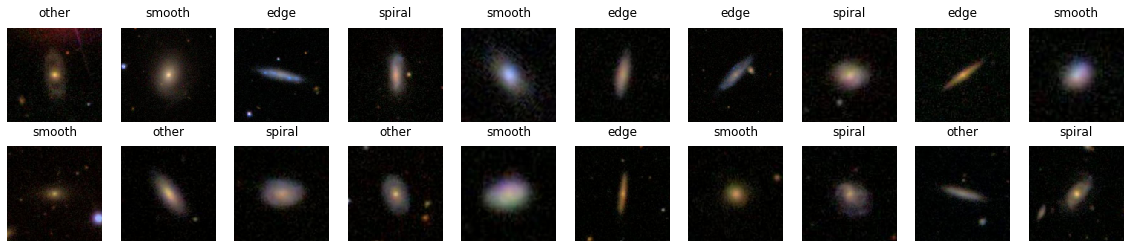

In [10]:
# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(20, 4))

# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    ax.matshow(X_train[idx], cmap='gray') 
    ax.set_title(target_dict[y_train[idx]])
    ax.axis('off')

In [11]:
y_train = tensorflow.keras.utils.to_categorical(y_train)
y_test = tensorflow.keras.utils.to_categorical(y_test)

In [12]:
X_train = np.asarray(X_train)
print('X_train shape:',X_train.shape)

y_train = np.asarray(y_train)
print('y_train shape:',y_train.shape)

X_test = np.asarray(X_test)
print('X_test shape:',X_test.shape)

y_test = np.asarray(y_test)
print('y_test shape:',y_test.shape)

X_train shape: (320, 128, 128, 3)
y_train shape: (320, 4)
X_test shape: (80, 128, 128, 3)
y_test shape: (80, 4)


In [16]:
model = Sequential()
# 16 3x3 kernels
model.add(Conv2D(16, kernel_size=(3, 3),activation='relu', input_shape=X_train.shape[-3:]))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# 32 3x3 kernels
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu'))
# Reduce by taking the max of each 2x2 block
model.add(MaxPooling2D(pool_size=(2, 2)))
# Dropout to avoid overfitting
model.add(Dropout(0.2))
# Flatten the results to one dimension for passing into our final layer
model.add(Flatten())
# A hidden layer to learn with
model.add(Dense(128, activation='relu'))
# Another dropout
model.add(Dropout(0.2))
# Final categorization from 0-9 with softmax
model.add(Dense(y_train.shape[-1], activation='softmax'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 126, 126, 16)      448       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 63, 63, 16)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 61, 61, 32)        4640      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 28800)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 128)              

In [17]:
# compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [18]:
# train the model
checkpointer = ModelCheckpoint(filepath='galaxy.cnn.best.hdf5', verbose=1, save_best_only=True)

history = model.fit(
    X_train, 
    y_train, 
    batch_size=32, 
    epochs=10,
    validation_data=(X_test, y_test), 
    callbacks=[checkpointer],
    verbose=2, 
    shuffle=True
)

Train on 320 samples, validate on 80 samples
Epoch 1/10

Epoch 00001: val_loss improved from inf to 1.37037, saving model to galaxy.cnn.best.hdf5
320/320 - 15s - loss: 1.4290 - acc: 0.2313 - val_loss: 1.3704 - val_acc: 0.2500
Epoch 2/10

Epoch 00002: val_loss improved from 1.37037 to 1.35272, saving model to galaxy.cnn.best.hdf5
320/320 - 13s - loss: 1.3507 - acc: 0.3688 - val_loss: 1.3527 - val_acc: 0.3625
Epoch 3/10

Epoch 00003: val_loss improved from 1.35272 to 1.25321, saving model to galaxy.cnn.best.hdf5
320/320 - 16s - loss: 1.2547 - acc: 0.5594 - val_loss: 1.2532 - val_acc: 0.4750
Epoch 4/10

Epoch 00004: val_loss improved from 1.25321 to 1.24994, saving model to galaxy.cnn.best.hdf5
320/320 - 16s - loss: 1.1210 - acc: 0.5500 - val_loss: 1.2499 - val_acc: 0.5000
Epoch 5/10

Epoch 00005: val_loss improved from 1.24994 to 1.22351, saving model to galaxy.cnn.best.hdf5
320/320 - 16s - loss: 1.0162 - acc: 0.6031 - val_loss: 1.2235 - val_acc: 0.4000
Epoch 6/10

Epoch 00006: val_loss 

In [19]:
# evaluate test accuracy
score = model.evaluate(X_test, y_test, verbose=0)
accuracy = 100*score[1]

# print test accuracy
print('Test accuracy: %.4f%%' % accuracy)

Test accuracy: 50.0000%


## Test classifier

In [20]:
img_files = np.array(glob("images/*"))
target_dict = {i: img_files[i].replace('images\\','') for i in range(len(img_files))}
target_dict

{0: 'edge', 1: 'other', 2: 'smooth', 3: 'spiral'}

In [21]:
trained_model = tensorflow.keras.models.load_model('galaxy.cnn.best.hdf5')

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


In [22]:
test_img_files = np.array(glob("test_files"))
test_img_files

array(['test_files'], dtype='<U10')

In [23]:
test_features, _ = load_images(test_img_files)

label 0/0 path: test_files 80 files


IntProgress(value=0, max=80)

In [24]:
test_features = np.asarray(test_features)
print('test_features shape:',test_features.shape)

test_features shape: (80, 128, 128, 3)


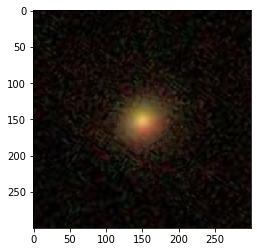

Predicted class: smooth


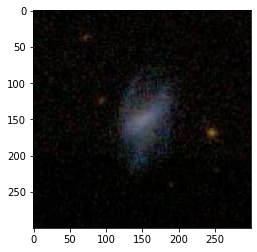

Predicted class: spiral


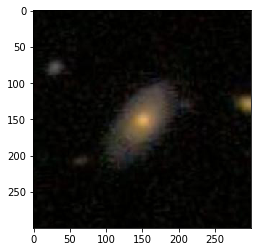

Predicted class: spiral


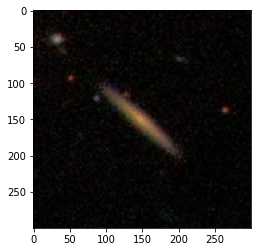

Predicted class: edge


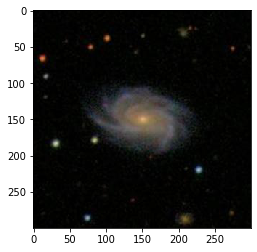

Predicted class: spiral


In [25]:
def print_class(features, idx):
    img = imread(os.path.join('test_files', os.listdir(test_img_files[0])[idx]), as_gray=False)
    plt.imshow(img)
    plt.show()
    # Results into dataframe
    result = trained_model.predict_classes(features[idx].reshape(1,128,128,3))
    return 'Predicted class: '+target_dict[result[0]]

# print i examples in the test images list
for i in np.random.choice(range(len(os.listdir(test_img_files[0]))-1), 5, replace=False):
    print(print_class(test_features, i))